https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

### Errors
- not masking the pad inputs for backprop
`

# Things you're trying and may need to change back
- batchnorm eval on cnn during training
- tanh non-linearity when projecting cnn output to embedding space
- using cnn output as first input to rnn instead of as hidden state -- what about SOS?
- Train embeddings or don't use w2v?

In [19]:
import torch
import re, pickle, collections, numpy as np, keras, math, operator, pdb
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torchvision.models import inception_v3
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import re
from os import path
from glob import glob
from torch.utils.data import DataLoader
from PIL import Image
from data_loader import get_loader
from build_vocab import build_vocab
from encoder import Encoder
from torch.nn.utils.rnn import pack_padded_sequence
from utils import *
from create_emb_matrix import create_emb_mat
from decoder import LSTMDecoder
import pdb
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
- You have tuples of image names and captions. 
- Pass those into your custom dataset. Along with your transform, vocab and root directory.
- implement the getitem function that loads and transforms the image. And also tokenizes and encodes the caption.
- then write your collate function.
- and get_loader function.

SyntaxError: invalid syntax (<ipython-input-2-988a52345229>, line 1)

In [25]:
dpath = '/data/image_captioning/flikr8/'
imgpath =  dpath + 'Flicker8k_Dataset/' 
tr_img_path = imgpath +'train/wrap'
dev_img_path = imgpath +'dev'
#samp_tr_img_path = imgpath + 'samp/train/wrap/'
MODEL_PREFIX = 'lstm_new'
BATCH_SIZE = 4

In [5]:
tr_caps = pickle.load(open(dpath+'train_first_caps.pkl', 'rb'))

In [7]:
vocab = build_vocab(tr_caps, 0)

[0/6000] Tokenized the captions.
[1000/6000] Tokenized the captions.
[2000/6000] Tokenized the captions.
[3000/6000] Tokenized the captions.
[4000/6000] Tokenized the captions.
[5000/6000] Tokenized the captions.


In [13]:
enc = Encoder(batch_size=BATCH_SIZE, emb_size=300, pool_size=8, fc_in_size=2048)
dec = LSTMDecoder(len(vocab), 300, 2)

if torch.cuda.is_available(): 
    enc.cuda()
    dec.cuda()

enc.load_state_dict(torch.load('models/enc_{}.pt'.format(MODEL_PREFIX), 
                               map_location=lambda storage, loc: storage))
dec.load_state_dict(torch.load('models/dec_{}.pt'.format(MODEL_PREFIX), 
                               map_location=lambda storage, loc: storage))


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


In [16]:
crit = nn.CrossEntropyLoss()

for epoch in range(1000):
    dl = get_loader(tr_img_path, tr_caps, vocab, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
    tot_loss = 0.0
    for i, (imgs, caps, ls) in enumerate(dl):
        #dl.dataset.sanity(imgs, caps, ls)
        #pdb.set_trace()
        imgs = to_var(imgs, volatile=True); caps = to_var(caps) #VOLATILE ON IMGS MAYBE?
        targets = pack_padded_sequence(caps, ls, batch_first=True)[0]
        imgs_enc = enc(imgs)

        out = dec(imgs_enc, caps, ls)
        loss = crit(out, targets)
        tot_loss += loss
        break
    print('epoch {} avg. loss: {}'.format(epoch, tot_loss.data[0] / (i + 1)))
    

epoch 0 avg. loss: 0.6675057411193848
epoch 1 avg. loss: 0.7485764026641846
epoch 2 avg. loss: 0.3660390079021454
epoch 3 avg. loss: 0.2269410341978073
epoch 4 avg. loss: 0.26406529545783997
epoch 5 avg. loss: 0.5405805706977844
epoch 6 avg. loss: 0.41977763175964355


Process Process-10:
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
Traceback (most recent call last):
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ryanryanadmin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(

KeyboardInterrupt: 

KeyboardInterrupt


### Train Sampling

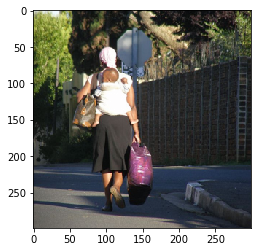

Predicted: <start> a woman carrying a purse and a bag with a baby in a backpack walking down a road .
True: <start> a woman carrying a purse and a bag with a baby in a backpack walking down a road . <end>


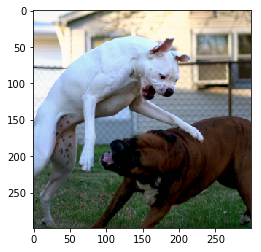

Predicted: <start> a white dog and a brown dog playing violently . <end> for a ball . <end> in a lake
True: <start> a white dog and a brown dog playing violently . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


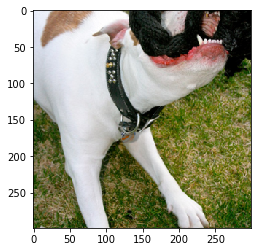

Predicted: <start> a dog playing with a toy . <end> in the water . <end> <end> . <end> . <end> .
True: <start> a dog playing with a toy . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


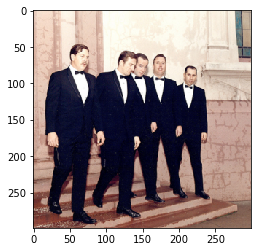

Predicted: <start> men in suits and ties walking downsteps <end> for the picture . <end> for another boy . <end> for
True: <start> men in suits and ties walking downsteps <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [21]:
dl = get_loader(tr_img_path, tr_caps, vocab, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
imgs, preds, true = sampleBatch(enc, dec, dl)
displaySamples(imgs, preds, true, vocab)

### Dev sampling

- You are overfitting.
- how to stop
- use w2v
- more dropout
- only one lstm layer
- smaller embedding size.

In [22]:
dev_caps = pickle.load(open(dpath+'dev_first_caps.pkl', 'rb'))

<start> a boy in a black helmet and red long sleeve shirt rides his motorbike over a rocky stream . <end>
caption length: 21
caption computed length: 21


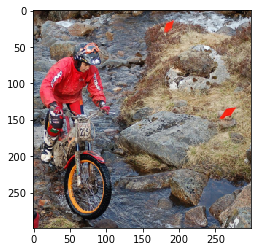

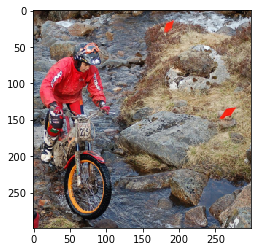

Predicted: <start> a group of bike riders are riding on the street . <end> for their opponent . <end> . <end>
True: <start> a boy in a black helmet and red long sleeve shirt rides his motorbike over a rocky stream . <end>


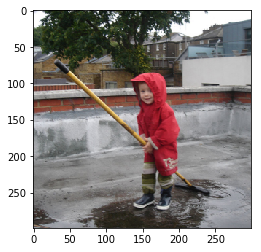

Predicted: <start> a boy sits in the snow while another follows behind . <end> . <end> in <end> . <end> .
True: <start> a boy in a red <unk> is riding a pool broom like a horse in an empty pool . <end>


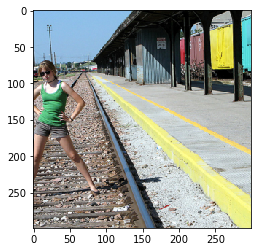

Predicted: <start> a man is playing a guitar for a little girl in a hospital . <end> for a girl .
True: <start> a girl poses on the train tracks near a station <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


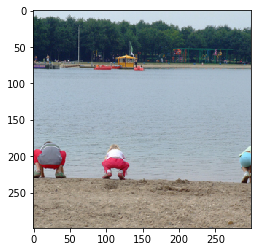

Predicted: <start> two girls are riding camels while another girl looks at them . <end> <end> . <end> . <end> .
True: <start> the three people are <unk> by the water . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [29]:
dl = get_loader(dev_img_path, dev_caps, vocab, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
imgs, preds, true = sampleBatch(enc, dec, dl)
displaySamples(imgs, preds, true, vocab)

### Dev Loss

In [7]:
enc.load_state_dict(torch.load('models/enc_{}.pt'.format(MODEL_PREFIX)))
dec.load_state_dict(torch.load('models/dec_{}.pt'.format(MODEL_PREFIX)))

In [18]:
def validate_dev(enc, dec, dev_caps=dev_caps, dev_img_path=dev_img_path, batch_size=BATCH_SIZE):
    enc.eval(); dec.eval()
    crit = nn.CrossEntropyLoss()
    dl = get_loader(dev_img_path, dev_caps, vocab, batch_size=batch_size, shuffle=True, num_workers=1)
    
    tot_loss = 0.0
    for i, (imgs, caps, ls) in enumerate(dl):
        #dl.dataset.sanity(imgs, caps, ls)
        #pdb.set_trace()
        imgs = to_var(imgs, volatile=True); caps = to_var(caps) #VOLATILE ON IMGS MAYBE?
        targets = pack_padded_sequence(caps, ls, batch_first=True)[0]
        imgs_enc = enc(imgs)

        out = dec(imgs_enc, caps, ls)
        loss = crit(out, targets)
        tot_loss += loss
    enc.train(); dec.train()
    return tot_loss.data[0] / i

In [19]:
enc = Encoder(batch_size=BATCH_SIZE, emb_size=300, pool_size=8, fc_in_size=2048)
dec = LSTMDecoder(len(vocab), 300, 2)

if torch.cuda.is_available(): 
    enc.cuda()
    dec.cuda()

LR = 0.001
params = list(dec.parameters()) + list(enc.linear.parameters()) + list(enc.bn.parameters())
optimizer = torch.optim.Adam(params, lr=LR)


In [20]:
crit = nn.CrossEntropyLoss()

for epoch in range(1000):
    dl = get_loader(tr_img_path, tr_caps, vocab, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
    best_loss = 1000.0
    tot_loss = 0.0
    for i, (imgs, caps, ls) in enumerate(dl):
        optimizer.zero_grad()
        
        #dl.dataset.sanity(imgs, caps, ls)
        #pdb.set_trace()
        imgs = to_var(imgs, volatile=True); caps = to_var(caps) #VOLATILE ON IMGS MAYBE?
        targets = pack_padded_sequence(caps, ls, batch_first=True)[0]
        imgs_enc = enc(imgs)

        out = dec(imgs_enc, caps, ls)
        loss = crit(out, targets)
        loss.backward()
        tot_loss += loss
        optimizer.step()
    avg_tr_loss = tot_loss.data[0] / (i +1)
    print('epoch {} avg. loss: {}'.format(epoch, avg_tr_loss))
    if (epoch + 1) % 5 == 0:
        avg_val_loss =  validate_dev(enc, dec)
        print('epoch {} avg val loss: {}'.format(epoch, avg_val_loss))
        if avg_val_loss < best_loss:
            torch.save(enc.state_dict(), 'models/enc_{}.pt'.format(MODEL_PREFIX))
            torch.save(dec.state_dict(), 'models/dec_{}.pt'.format(MODEL_PREFIX))
            torch.save(optimizer.state_dict(), 'models/opt_{}.pt'.format(MODEL_PREFIX))
            best_loss = avg_val_loss
        

epoch 0 avg. loss: 4.732233220880682
epoch 1 avg. loss: 3.652359743169285
epoch 2 avg. loss: 3.366281764392547
epoch 3 avg. loss: 3.1827960498830214
epoch 4 avg. loss: 3.038723379532921
epoch 4 avg val loss: 3.345093282063802
epoch 5 avg. loss: 2.932257177995488
epoch 6 avg. loss: 2.8398555000835564
epoch 7 avg. loss: 2.759361552682152
epoch 8 avg. loss: 2.6880901153074865
epoch 9 avg. loss: 2.6238199325806315
epoch 9 avg val loss: 3.2283045450846353
epoch 10 avg. loss: 2.5684368929123496
epoch 11 avg. loss: 2.511904629794034
epoch 12 avg. loss: 2.4577468627276904
epoch 13 avg. loss: 2.412554572610294
epoch 14 avg. loss: 2.364499341995321
epoch 14 avg val loss: 3.230982716878255
epoch 15 avg. loss: 2.318453538864054


Process Process-37:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/nbs/data_loader.py", line 49, in __getitem__
    image = self.transform(image)
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 42, in __call__
    img = t(img)
  File "/home/ubuntu/anaco

KeyboardInterrupt: 